## First Step: generate non-uniform sampling (NUS)

function: cs.GenPoissonDist()
Input: 
- total_number_of_indices
- number_of_samples
Output:
- subset of indices

In [1]:
from spin_correlator_app import correlation_function, NMRCorrelationSimulator
from struqture_py import spins
import numpy as np
import compressed_sensing as cs

#TODO:add spectrometer frequency

total_number_of_indices = 1000
max_time = np.pi*100
print('Max t:',max_time)

full_time_range = np.linspace(0, max_time, total_number_of_indices)
percentage =0.1 #from 0 to 1

number_of_samples = round(total_number_of_indices*percentage) # number of subsample of full_time_range
print('Number of samples:', number_of_samples)

subset = cs.GenPoissonDist(number_of_samples,total_number_of_indices, usenumpy=True)
print('Subset of points (NUS sampling):'+str(len(subset))+' points',subset)

Copyright © 2021-2022 HQS Quantum Simulations GmbH. All Rights Reserved.
Struqture python interface
Copyright © 2021-2022 HQS Quantum Simulations GmbH. All Rights Reserved.

 Licensed under conditions specified in LICENSE file for source distribution and LICENSE_FOR_BINRARY_DISTRIBUTION for binary distribution.
Max t: 314.1592653589793
Number of samples: 100
Subset of points (NUS sampling):100 points [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 18, 20, 22, 23, 24, 26, 27, 29, 31, 35, 37, 40, 42, 46, 52, 54, 56, 59, 64, 70, 76, 80, 84, 87, 90, 93, 98, 104, 111, 117, 121, 129, 135, 144, 146, 155, 159, 169, 174, 181, 193, 206, 212, 223, 232, 245, 250, 261, 271, 285, 301, 311, 325, 342, 356, 374, 386, 403, 417, 440, 457, 471, 483, 504, 513, 531, 549, 572, 588, 620, 643, 668, 694, 716, 730, 751, 775, 805, 820, 843, 859, 886, 900, 927, 950, 974, 992]


# Step2: generate spin-correlators signal (full signal)

In [2]:
# Set up the spin system, and define the spin-correlator function
gyromagnetic = 1.0
number_qubits = 2
# times = [np.pi/10*x for x in range(number_of_samples)]
coupling = 1.0
shift = 1.0
gyromagnetic_factors = [gyromagnetic for _ in range(number_qubits)]

hamiltonian = spins.SpinHamiltonianSystem()
for i in range(number_qubits):
    hamiltonian.add_operator_product(spins.PauliProduct().z(i), -shift * i)
for i in range(number_qubits - 1):
    hamiltonian.add_operator_product(spins.PauliProduct().x(i).x(i + 1), coupling)
    hamiltonian.add_operator_product(spins.PauliProduct().y(i).y(i + 1), coupling)

# correlators = correlation_function(hamiltonian, gyromagnetic_factors, times, number_trottersteps = 10, dephasing = 0.001)
full_correlators = correlation_function(hamiltonian, gyromagnetic_factors, full_time_range, number_trottersteps = 10, dephasing = 0.001)

Plot full signal vs sub-sampling

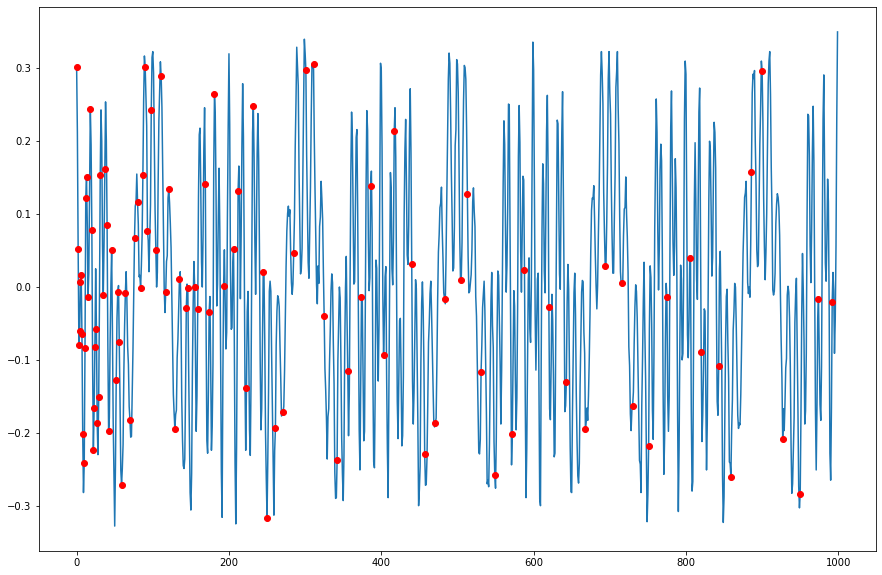

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
plt.plot(full_correlators['spin_total'], label='full correlators')

correlators = [full_correlators['spin_total'][index] for  index in subset]
plt.plot(subset,correlators,linestyle='none', marker='o', color='red', label='subset of points')
# new figure



Generate matrix for invese Fourier transform

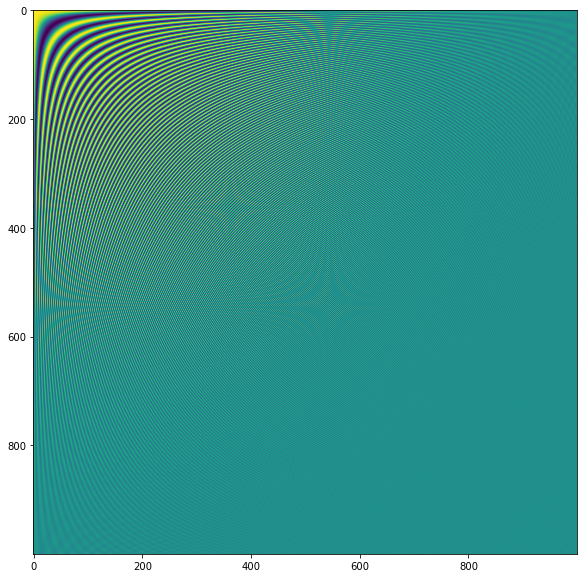

In [4]:
# create idct matrix operator in order to perform inverse DCT
import scipy.fftpack as spfft
A = spfft.idct(np.identity(total_number_of_indices), norm='ortho', axis=0) 
# Inverse Cosine Discrete Transform is the inverse of the DCT. 
# DCT is a discrete transform of the signal from the time domain to the frequency domain.

if total_number_of_indices<=1000:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(A)

## STEP 3: Compressed sensing (CS) reconstruction
Reconstruct signal from sub-sampling. Use inverse Fourier transform matrix to reconstruct signal, minimizing L1 norm.

Using function cs.CS_Recontruction()
Input:
- matrix of inverse Fourier transform (IDCT)
- sub-sampling correlator
- subset of points (to get a submatrix from the original IDCT matrix)

In [5]:
# reconstruct the full signal using the inverse DCT
full_signal = spfft.dct(full_correlators['spin_total'], norm='ortho') # DCT of the signal, Discrete Cosine Transform ,Fourier Transform

print('\n\nSubset:(',percentage*100,'% of the full signal)','(',len(subset),'samples)')

# reconstruct signal from subset of points
signal_reconstruced, result_info = cs.CS_Reconstruction(A,correlators,subset)



Subset:( 10.0 % of the full signal) ( 100 samples)
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 30 04:42:52 PM: Your problem has 1000 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 30 04:42:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 30 04:42:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 30 04:42:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 30 04:42:52 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 30 04:42:52 PM: Reduction cha

/home/gsilvi/miniforge3/envs/MERCK/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


14  +2.203e+01  +2.203e+01  +7e-04  2e-06  6e-09  3e-07  3e-07  0.8253  6e-02   1  1  1 |  0  0
15  +2.203e+01  +2.203e+01  +2e-04  7e-07  2e-09  1e-07  1e-07  0.8415  2e-01   1  1  1 |  0  0
16  +2.203e+01  +2.203e+01  +3e-06  9e-09  2e-11  1e-09  1e-09  0.9866  1e-04   1  1  1 |  0  0
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Aug 30 04:42:52 PM: Problem status: optimal
(CVXPY) Aug 30 04:42:52 PM: Optimal value: 2.203e+01
(CVXPY) Aug 30 04:42:52 PM: Compilation took 3.952e-02 seconds
17  +2.203e+01  +2.203e+01  +3e-08  1e-10  3e-13  1e-11  2e-11  0.9890  1e-04   1  1  1 |  0  0

OPTIMAL (within feastol=1.0e-10, reltol=1.4e-09, abstol=3.0e-08).
Runtime: 0.192517 seconds.

(CVXPY) Aug 30 04:42:52 PM: Solver (including time spent in interface) took 1.930e-01 seconds


Plot full signal vs reconstructed signal

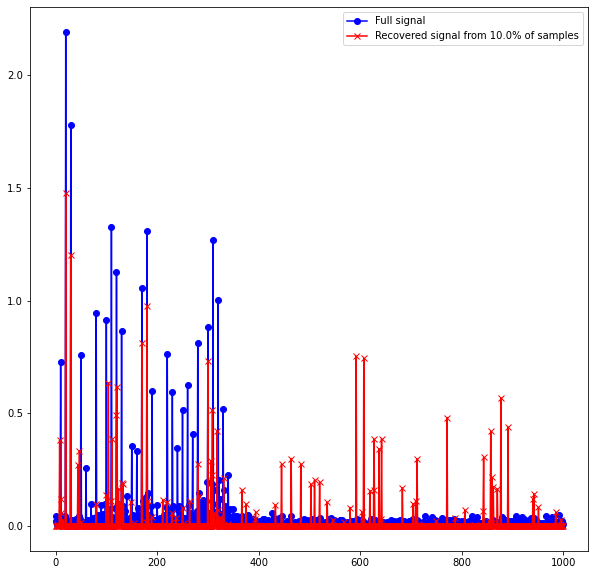

In [6]:
plt.figure(figsize=(10,10))
plt.plot(np.abs(full_signal),marker='o',color='blue',label='Full signal')
plt.plot(np.abs(signal_reconstruced.value),marker='x',color='red', label='Recovered signal from '+ str(percentage*100)+'% of samples')
plt.legend()
